<a href="https://colab.research.google.com/github/melvy13/fruitveg-classifier-model/blob/main/img_classify_ai_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup**

---

Due to security reasons, the dataset download link is not included as it contains a private key.

Insert the download link manually before running the other blocks:

In [2]:
# To insert dataset download link manually before running
# e.g. https://app.roboflow.com/ds/abcde12345?key=fghij67890

original_data = "LINK"

!curl -L "{original_data}" -o roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: test/apple_unripe/apple_unripe_190_jpg.rf.c0d2a4ae496b64f941511e1ff6c69867.jpg  
 extracting: test/apple_unripe/apple_unripe_23_jpg.rf.7442258c927437dabad181f848f8fd75.jpg  
 extracting: test/apple_unripe/apple_unripe_24_jpg.rf.3fde5cc5d582ff48c8aa9c4d636c29af.jpg  
 extracting: test/apple_unripe/apple_unripe_44_jpg.rf.f74741c6b5b7a6e7fcaf46f5bfe068c6.jpg  
 extracting: test/apple_unripe/apple_unripe_55_jpg.rf.6dfdbf150d3931ca06c4855694f0081d.jpg  
 extracting: test/apple_unripe/apple_unripe_63_jpg.rf.68b25acc751ba9b7f1e10c5ad6608aa8.jpg  
 extracting: test/apple_unripe/apple_unripe_69_jpg.rf.4ee63eeabd2ff4054f6ca423deeb8e34.jpg  
 extracting: test/apple_unripe/apple_unripe_6_jpg.rf.420c892f6b0ce25aeac02293bd07a667.jpg  
 extracting: test/apple_unripe/apple_unripe_79_jpg.rf.8d839301fbcb3241a6f24c8026521fe3.jpg  
 extracting: test/apple_unripe/apple_unripe_96_jpg.rf.2bfa0b7b1649c88254560fe3270b9dd8.jpg  
   creating: test/b

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

**Load dataset**

---



In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # 224x224 images
NUM_CLASSES = 10      # 10 categories
EPOCHS = 50
TRAIN_DIR = 'train'
VALID_DIR = 'valid'
TEST_DIR = 'test'

# Load training data
print("Loading training data...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

print("Loading validation data...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

print("Loading test data...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

class_names = train_dataset.class_names
print("\nFound classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Loading training data...
Found 4500 files belonging to 10 classes.
Loading validation data...
Found 300 files belonging to 10 classes.
Loading test data...
Found 200 files belonging to 10 classes.

Found classes: ['apple_ripe', 'apple_unripe', 'banana_ripe', 'banana_unripe', 'broccoli_cooked', 'broccoli_raw', 'carrot_cooked', 'carrot_raw', 'mango_ripe', 'mango_unripe']


**Build the MobileNetV2 Model**

---



In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,610 (9.89 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

**Train the model**

---



In [ ]:
# Use Sparse Categorical Cross-entropy for loss function & Adam for optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_list = [
    # Save the best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    ),
    # Stop if no improvement for 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    # Automatically reduce LR if no improvement
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

print("\nStarting initial training (training the 'head')...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks_list
)

print("Model trained")


Starting initial training (training the 'head')...
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 224ms/step - accuracy: 0.8099 - loss: 1.0098 - val_accuracy: 0.9833 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9821 - loss: 0.4538 - val_accuracy: 0.9767 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9919 - loss: 0.3787 - val_accuracy: 0.9767 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9970 - loss: 0.3144 - val_accuracy: 0.9867 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9940 - loss: 0.2656 - val_accuracy: 0.9700 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9911 - loss: 0.2296 - val_accuracy: 0.9667 - val_loss: 0.2880 - learning_rate: 0.0010
Epoch 7/50
141/141 ━━━━━━━━━

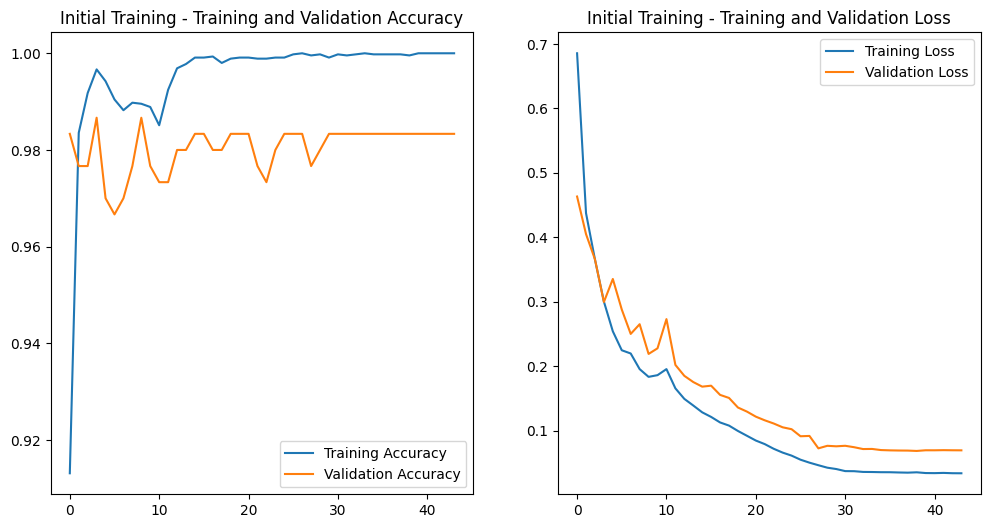

In [ ]:
# Function to plot accuracy and loss
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')

    plt.show()

plot_history(history, "Initial Training")

**Fine-Tuning**

---



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,610 (9.89 MB)

 Trainable params: 2,194,506 (8.37 MB)

 Non-trainable params: 399,104 (1.52 MB)


Starting fine-tuning...
Epoch 44/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 181ms/step - accuracy: 0.9620 - loss: 0.1593 - val_accuracy: 0.9800 - val_loss: 0.0893 - learning_rate: 1.0000e-05
Epoch 45/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9826 - loss: 0.0890 - val_accuracy: 0.9767 - val_loss: 0.0926 - learning_rate: 1.0000e-05
Epoch 46/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9899 - loss: 0.0713 - val_accuracy: 0.9800 - val_loss: 0.0805 - learning_rate: 1.0000e-05
Epoch 47/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9956 - loss: 0.0527 - val_accuracy: 0.9833 - val_loss: 0.0743 - learning_rate: 1.0000e-05
Epoch 48/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9937 - loss: 0.0539 - val_accuracy: 0.9833 - val_loss: 0.0664 - learning_rate: 1.0000e-05
Epoch 49/70
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9971 - loss: 0.0464 - val_accuracy: 0.9867 - val_loss: 0.0619 - learning_rate: 1.0000e-05
Epoch 50/70
141/141 ━━━━━

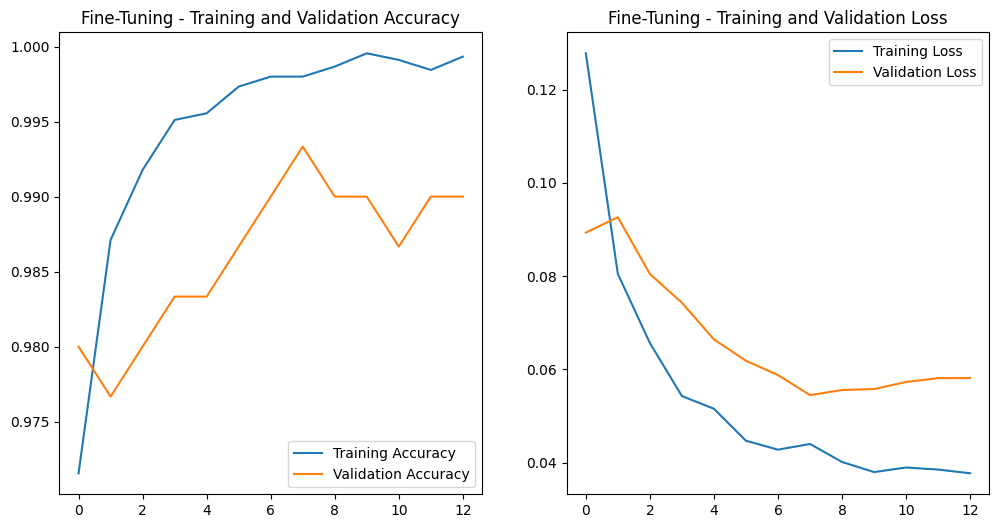

In [ ]:
# Unfreeze base model
base_model.trainable = True

# Freeze first 100 layers, only train top layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train for few more epochs
print("\nStarting fine-tuning...")
FINE_TUNE_EPOCHS = 20
total_epochs = EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=callbacks_list
)

# Plot the fine-tuning results
plot_history(history_fine, "Fine-Tuning")

In [ ]:
print("\nEvaluating model on the 'test' dataset...")

results = model.evaluate(test_dataset)

print("---" * 10)
print(f"Test Loss:     {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print("---" * 10)


Evaluating model on the 'test' dataset...
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9626 - loss: 0.1241
------------------------------
Test Loss:     0.0834
Test Accuracy: 98.00%
------------------------------


Getting predictions and true labels...
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 705ms/step

---------------------------------------------
🎯 CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

     apple_ripe       1.00      1.00      1.00        20
   apple_unripe       1.00      0.85      0.92        20
    banana_ripe       1.00      1.00      1.00        20
  banana_unripe       1.00      0.95      0.97        20
broccoli_cooked       1.00      1.00      1.00        20
   broccoli_raw       1.00      1.00      1.00        20
  carrot_cooked       1.00      1.00      1.00        20
     carrot_raw       1.00      1.00      1.00        20
     mango_ripe       1.00      1.00      1.00        20
   mango_unripe       0.83      1.00      0.91        20

       accuracy                           0.98       200
      macro avg       0.98      0.98      0.98       200
   weighted avg       0.98      0.98      0.98       200

---------------------------------------------

📊 

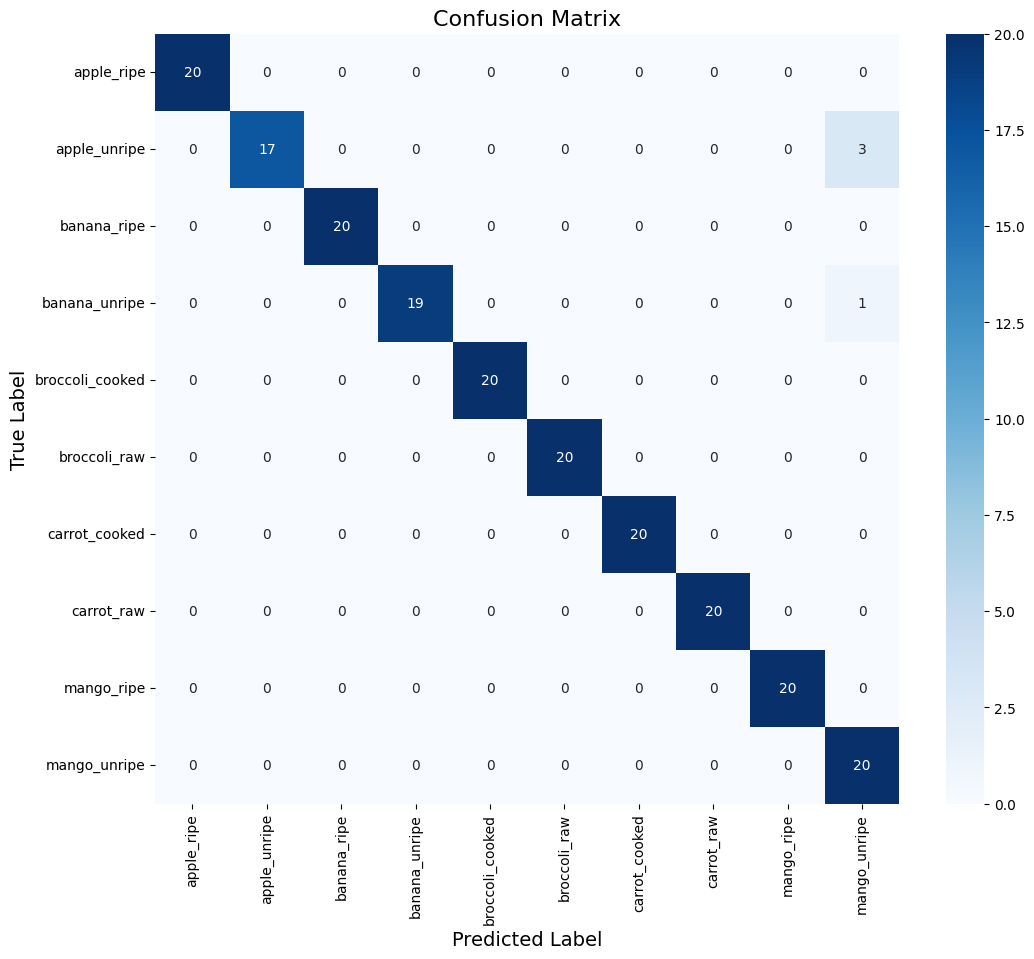

Scanning for errors...
Found 4 misclassified images. Displaying...


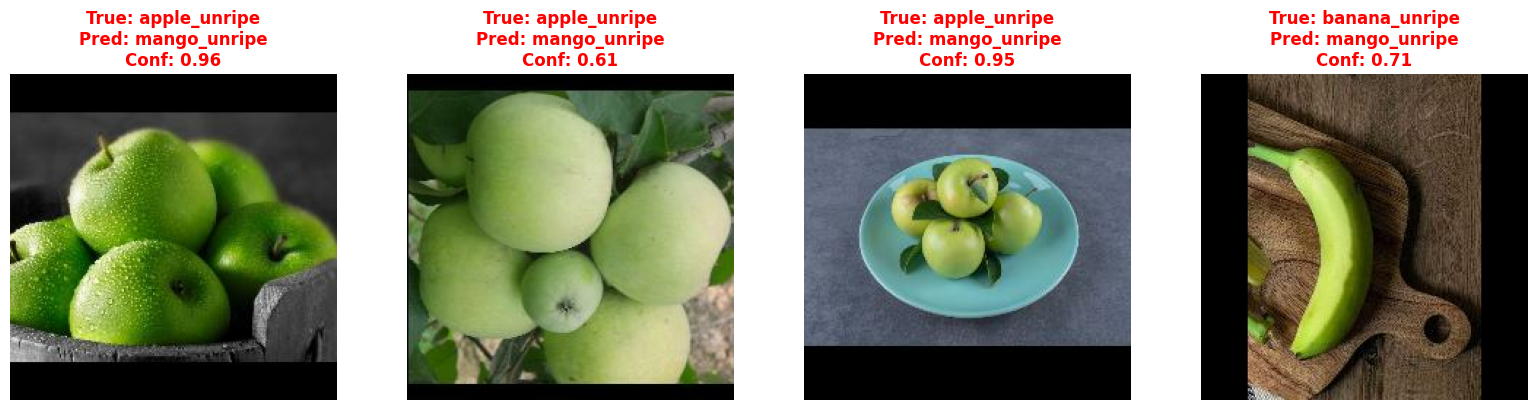

In [ ]:
print("Getting predictions and true labels...")
# Get all predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

print("\n" + "---" * 15)
print("🎯 CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("---" * 15 + "\n")

print("📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

def display_misclassified_images(dataset, model, class_names, num_images=10):
    misclassified_data = []

    print("Scanning for errors...")

    # Iterate through the dataset batch by batch
    for images, labels in dataset:
        # Get predictions for this batch
        preds_probs = model.predict(images, verbose=0)
        preds_classes = np.argmax(preds_probs, axis=1)

        # Convert labels to numpy
        true_classes = labels.numpy()

        # Check every image in the batch
        for i in range(len(true_classes)):
            if preds_classes[i] != true_classes[i]:
                # Store error if found
                misclassified_data.append({
                    'image': images[i].numpy(),
                    'true_idx': true_classes[i],
                    'pred_idx': preds_classes[i],
                    'confidence': np.max(preds_probs[i])
                })

            if len(misclassified_data) >= num_images:
                break
        if len(misclassified_data) >= num_images:
            break

    if not misclassified_data:
        print("No misclassified images found!")
        return

    print(f"Found {len(misclassified_data)} misclassified images. Displaying...")

    # Plotting
    cols = 5
    rows = (len(misclassified_data) + cols - 1) // cols

    plt.figure(figsize=(20, 4 * rows))

    for i, data in enumerate(misclassified_data):
        ax = plt.subplot(rows, cols, i + 1)

        img_display = data['image'].astype("uint8")
        plt.imshow(img_display)

        true_label = class_names[data['true_idx']]
        pred_label = class_names[data['pred_idx']]
        conf = data['confidence']

        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}",
                  color='red', fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_misclassified_images(test_dataset, model, class_names, num_images=15)

In [ ]:
model.save('fruitveg_classifier_model.keras')
print("Model saved as 'fruitveg_classifier_model.keras'")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('fruitveg_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nModel saved as 'fruitveg_classifier.tflite'")

Model saved as 'fruitveg_classifier_model.keras'
Saved artifact at '/tmp/tmpr4s3814x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133556290423696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290425424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290426768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290425616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290425040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290425232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290427728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290428496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290428112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133556290426384: TensorSpec(sh